In [5]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d computingvictor/transactions-fraud-datasets -f transactions_data.csv
!unzip transactions_data.csv.zip


Dataset URL: https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets
License(s): apache-2.0
transactions_data.csv: Skipping, found more recently modified local copy (use --force to force download)
unzip:  cannot find or open transactions_data.csv.zip, transactions_data.csv.zip.zip or transactions_data.csv.zip.ZIP.


In [6]:
# import dependecies
import pandas as pd

# read csv file into pandas dataframe
df = pd.read_csv('transactions_data.csv')

print(df.head(20))
print(df.info())



         id                 date  client_id  card_id   amount  \
0   7475327  2010-01-01 00:01:00       1556     2972  $-77.00   
1   7475328  2010-01-01 00:02:00        561     4575   $14.57   
2   7475329  2010-01-01 00:02:00       1129      102   $80.00   
3   7475331  2010-01-01 00:05:00        430     2860  $200.00   
4   7475332  2010-01-01 00:06:00        848     3915   $46.41   
5   7475333  2010-01-01 00:07:00       1807      165    $4.81   
6   7475334  2010-01-01 00:09:00       1556     2972   $77.00   
7   7475335  2010-01-01 00:14:00       1684     2140   $26.46   
8   7475336  2010-01-01 00:21:00        335     5131  $261.58   
9   7475337  2010-01-01 00:21:00        351     1112   $10.74   
10  7475338  2010-01-01 00:23:00        554     3912    $3.51   
11  7475339  2010-01-01 00:23:00        605     5061    $2.58   
12  7475340  2010-01-01 00:26:00       1556     2972   $39.63   
13  7475341  2010-01-01 00:27:00       1797     1127   $43.33   
14  7475342  2010-01-01 0

In [7]:
#Subset portion of the dataset for more thorough manual data inspection
transactions_ss = df.iloc[0:50, 0:11 ]
transactions_ss.to_csv('transactions_ss.csv', index=False)

In [8]:
# Remove any '$' signs or commas, then convert to float
df['amount'] = df['amount'].replace('[\$,]', '', regex = True).astype(float)


In [9]:
# Convert date to datetime
df['timestamp'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df.drop(columns=['date'], inplace=True)

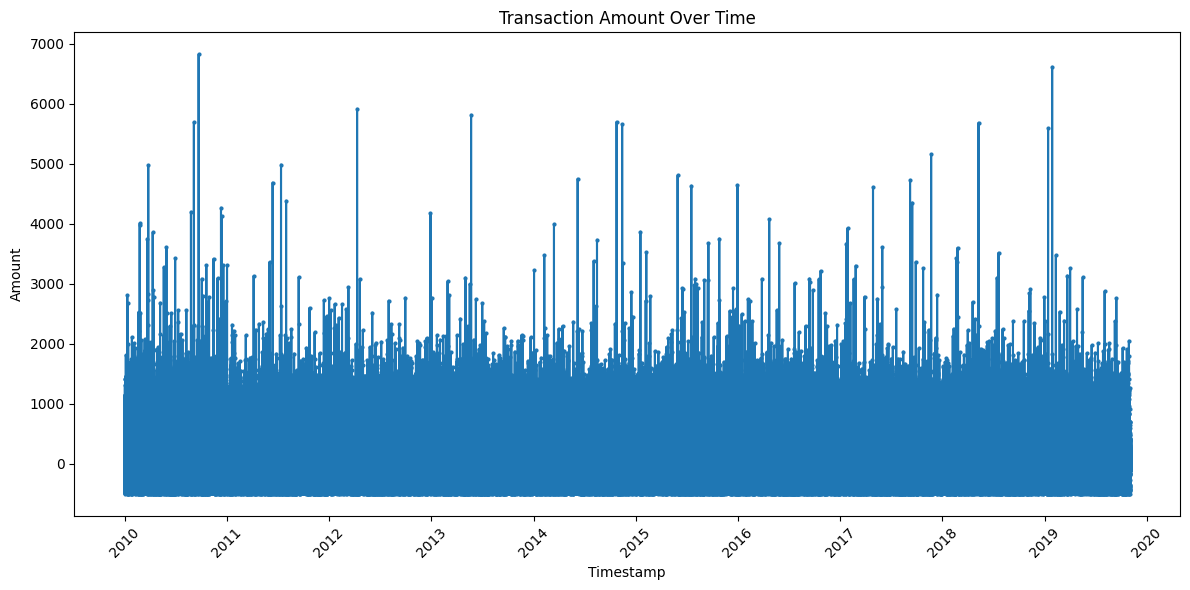

In [10]:
import matplotlib.pyplot as plt

# Plot transaction amounts over time
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['amount'], marker='o', linestyle='-', markersize=2)
plt.xlabel('Timestamp')
plt.ylabel('Amount')
plt.title('Transaction Amount Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
#Compute average amount and standard deviation per client and left join result
clients_stats = df.groupby('client_id')['amount'].agg(['mean', 'std']).reset_index()
df = df.merge(clients_stats, on = 'client_id', how = 'left', suffixes = ('','_client'))


# Calculate Z-score for each transaction amount (deviation from client average)
df['amount_zscore'] = (df['amount'] - df['mean']) / df['std']

In [12]:
from sklearn.ensemble import IsolationForest

# Select features for anomaly detection (e.g., amount_zscore, transaction velocity, location mismatch)
features = ['amount_zscore']  # Add more features as needed

# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(df[features])

# Mark anomalies (typically, -1 indicates an outlier)
df['risk_flag'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# View the flagged transactions
print(df[df['risk_flag'] == 1].head())


         id  client_id  card_id  amount            use_chip  merchant_id  \
3   7475331        430     2860  200.00   Swipe Transaction        27092   
8   7475336        335     5131  261.58  Online Transaction        50292   
28  7475358        401     3004  669.88   Swipe Transaction        68977   
35  7475365        820      127  270.22  Online Transaction        73186   
44  7475376        989     2511  580.98   Swipe Transaction        73661   

   merchant_city merchant_state      zip   mcc errors           timestamp  \
3    Crown Point             IN  46307.0  4829    NaN 2010-01-01 00:05:00   
8         ONLINE            NaN      NaN  7801    NaN 2010-01-01 00:21:00   
28   West Covina             CA  91791.0  3174    NaN 2010-01-01 00:48:00   
35        ONLINE            NaN      NaN  4814    NaN 2010-01-01 01:01:00   
44  Thackerville             OK  73459.0  7995    NaN 2010-01-01 01:19:00   

          mean         std  amount_zscore  anomaly_score  risk_flag  
3    52.82

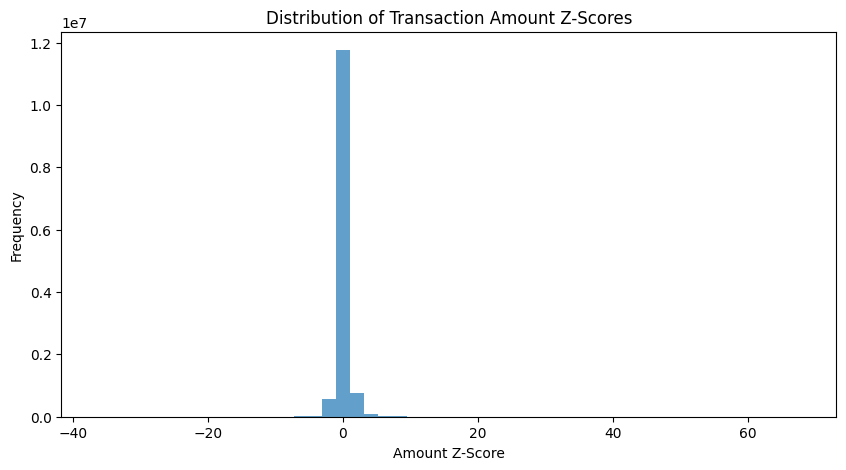

In [13]:
# Example: Visualizing the distribution of a custom risk score
plt.figure(figsize=(10, 5))
plt.hist(df['amount_zscore'], bins=50, alpha=0.7)
plt.xlabel('Amount Z-Score')
plt.ylabel('Frequency')
plt.title('Distribution of Transaction Amount Z-Scores')
plt.show()
